**MONTECARLO MODEL for STOCK PREDICTION**

Libraries to import

In [11]:
##Generic library for Array and Data-time format
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame

##Generic library to create plots
import plotly.graph_objects as go
import plotly.subplots as sp

##Generic library to retrieve stock-Data
import yfinance as yf



In [12]:
##Return the yfinance.Ticker object that stores all the relevant stock informations
import warnings

##Return the DATA INFORMATIONS
def month_year():
    now = dt.datetime.now()
    return now.day, now.month, now.year

def get_stock_data(isin_string):
    try:
        stock_ticker = isin_string
        stock_data = yf.Ticker(stock_ticker)
        stock_info = stock_data.info  # Effettua una richiesta per ottenere le informazioni
        return stock_data
    except ValueError as e:
        print(f"Errore nel recuperare i dati per {isin_string}: {e}")
        return None
    except Exception as e:
        print(f"Si è verificato un errore non previsto per {isin_string}: {e}")
        return None



##Return the hystorical data with date expressed as string --> Suitable for calculations
def get_stock_with_date_index_data(
    stock_data, category, start_date, end_date, ma_period=200
) -> DataFrame | DataFrame:
    full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    try:
        if isinstance(stock_data, yf.Ticker):
            hist_data = stock_data.history(start=start_date, end=end_date)
            hist_data.index = hist_data.index.strftime("%Y-%m-%d")
            hist_data = hist_data.reindex(full_date_range.strftime("%Y-%m-%d"))
            hist_data.infer_objects().ffill(inplace=True)

            hist_data_to_return = pd.DataFrame(
                index=full_date_range.strftime("%Y-%m-%d"),
                columns=["symbol","category","stock_price", "volume", "MA200", "OBV"],
            )
            hist_data_to_return["stock_price"] = hist_data["Close"]
            hist_data_to_return["volume"] = hist_data["Volume"]
            hist_data_to_return["category"] = category
            hist_data_to_return["symbol"] = stock_data.ticker
            hist_data_to_return["MA200"] = (
                hist_data_to_return["stock_price"].rolling(window=ma_period).mean()
            )

            # Calcolo dell'indicatore OBV
            hist_data_to_return["OBV"] = np.where(
                hist_data_to_return["stock_price"].diff() > 0,  # type: ignore
                hist_data_to_return["volume"],
                -hist_data_to_return["volume"],
            )
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', FutureWarning)
                hist_data_to_return.ffill(inplace=True)
            return hist_data_to_return
        else:
            raise ValueError(f"stock_data must be a yf.Ticker object, got {type(stock_data)} instead.")
    except Exception as e:
        print(f"Error: {e}")
        hist_data_to_return = pd.DataFrame(
            index=full_date_range.strftime("%Y-%m-%d"),
            columns=["symbol","stock_price", "volume", "MA200", "OBV"],
        )
        return hist_data_to_return

This Montecarlo Model is built based on the definition of **daily logarithmic return (dlr)** as function of the **drift** and **volatility** :

$$
dlr = ln \frac{price\_today}{price\_yesterday} \rightarrow price\_today = \exp{(dlr)} * price\_yesterday 
$$

$$
drift \sim mean(dlr) - \frac{\hat{V}(dlr)}{2}   
$$ 

$$
volatility \sim \sigma(dlr) * Z 
$$

$$
dlr = drift + volatility
$$

Where **Z** is coming from a chosen random distribution (i.e. normal, uniform)

Here, we start to retrieve data from the ticker that we are interested.

In [32]:
### GENERIC INFORMATION ABOUT stock and its HYSTORICAL BEHAVIOR
# Time Informations
day, month, year = month_year()

##stock_under_test = input("Enter the stock ticker symbol: ")
##start_date = input("Enter the start date (YYYY-MM-DD): ")
##category = input("Insert Category ETF, Crypto, Stock")
stock_under_test = "GME"
start_date = "2021-01-01"
category = "Stock"

##end_date = "2021-06-08"

end_date = f"{year}-{month}-{day}"

stock_data_object = get_stock_data(stock_under_test)
stock_dataFrame   = get_stock_with_date_index_data(stock_data=stock_data_object,category=category,start_date=start_date,end_date=end_date,ma_period=200)

stock_prices      = (stock_dataFrame["stock_price"])
#Last value of the Ticker
#stock_dataFrame["stock_price"].iloc[-1]

In [46]:
## Daily Logarithmic Return

logret      = np.log(stock_prices/stock_prices.shift(1))

## Drift and Volatility
number_simulation = 10**7

## Z           = np.random.uniform(-1,+1,number_simulation)
Z           = np.random.normal(0,1,(number_simulation)) 

drift       = np.mean(logret) - - np.var(logret)/2
volatility  = np.std(logret) * Z 

Average Stock Today Price : 0    73.622363
dtype: float64


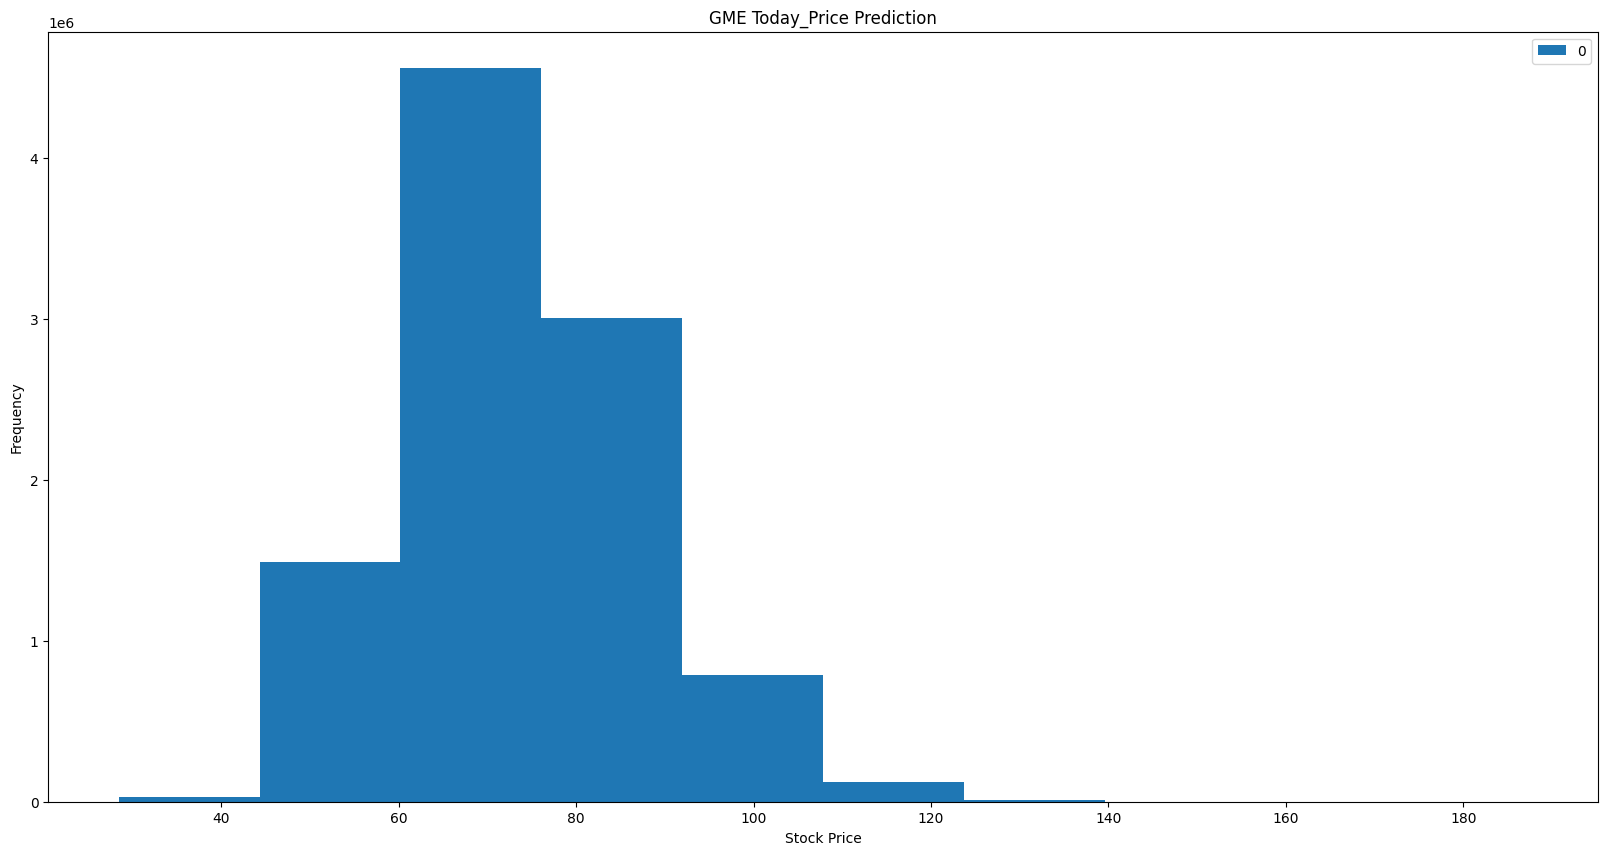

In [47]:
## Today Price calculation

today_price = stock_prices.iloc[-1] * np.exp(drift+volatility)

df_today_price = pd.DataFrame(today_price)
df_today_price.plot(kind='hist', title=f"{stock_under_test} Today_Price Prediction",figsize=(20,10),xlabel="Stock Price",ylabel="Frequency")

print(f"Average Stock Today Price : {df_today_price.mean()}")